In [1]:

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
import xgboost as xgb
from xgboost import XGBRegressor
import joblib
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

# Configuración para la visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## Data Loading

In [2]:

# Carga de los datos
data_path = '/Users/fernandopradagorge/Documents/Documentos - MacBook Pro de Fernando/Universidad/Master Data Science and AI/Nuclio Projects/Entregables/Entregable_3_Kaggle_31MAR24/ML_Time_Series/ts_kaggle_train.csv'  # Asegúrate de tener la ruta correcta al archivo
df = pd.read_csv(data_path)

# Visualización de las primeras filas del conjunto de datos
df.head()


,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [3]:
# Información general del DataFrame
df.info()

# Estadísticas descriptivas
df.describe()

# Verificación de valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14484 non-null  int64  
 1   date                   14484 non-null  object 
 2   unique_id              14484 non-null  object 
 3   city_id                14484 non-null  int64  
 4   shop_id                14484 non-null  int64  
 5   item_category_id       14484 non-null  int64  
 6   item_id                14484 non-null  int64  
 7   monthly_average_price  13262 non-null  float64
 8   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1018.5+ KB


Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [4]:
# Cambio la fecha a un formato adecuado para trabajar con ella
df["date"] = pd.to_datetime(df["date"], format= "%Y-%m-%d")

In [5]:
# Voy a comprobar cuantas series temporales tiene el dataset:
df["unique_id"].nunique()

426

In [6]:
# Ahora cuantos meses
len(df["date"].unique())

34

In [7]:
df.shape

(14484, 9)

In [8]:
# Una vez comprobados los demás elementos , voy a ver cuales son las fechas mínimas y máximas del dataset:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [9]:
# Vuelvo a comprobar los nulos que tengo en el dataset
df.isnull().sum()

Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

## Data Imputation

In [10]:
# Procedo a rellenar los valores NaN con 0
df.fillna({"monthly_sales":0}, inplace=True)

In [11]:
df["monthly_average_price"] = df.groupby("unique_id")["monthly_average_price"].transform(
    lambda x: x.ffill().bfill()
)

In [12]:
# Compruebo si he imputado los nulos correctamente
df.isnull().sum()

Unnamed: 0               0
date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [13]:
df.sort_values(["unique_id", "date"], ascending = True)

,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...,...
14435,14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


## EDA

In [14]:
def plot_ts_acf_pacf(y, title):
    fig = plt.figure(figsize=(12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax= ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [15]:
y = df.set_index("date").resample("ME")["monthly_sales"].sum()[:-1] # Con esta función elimino los registros de Octubre porque es lo que voy a predecir

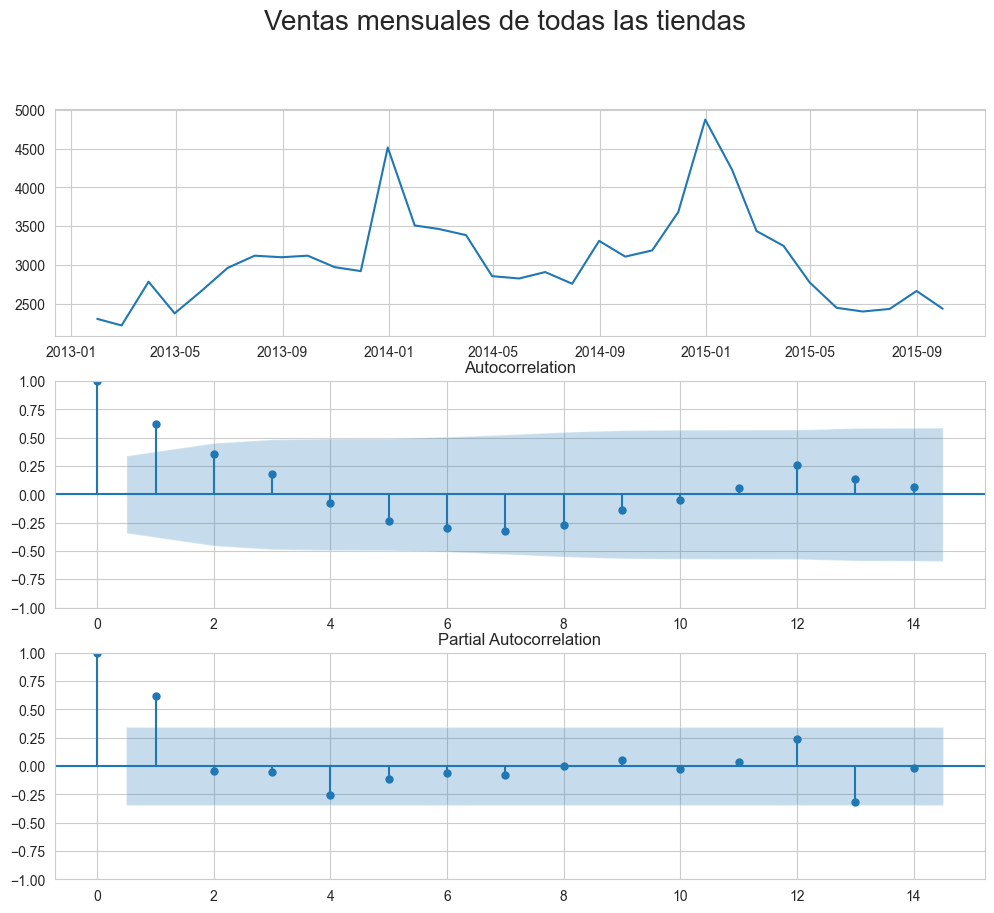

In [16]:
# Muestro una gráfica de las ventas mensuales de todas las tiendas
plot_ts_acf_pacf(y = y, title="Ventas mensuales de todas las tiendas")

## Clustering

In [17]:
# Voy a agrupar los datos en clusters para trabajar con ellos de forma mas sencilla.
# Extraigo las características con tsfresh
extracted_features = extract_features(df, column_id="unique_id", column_sort="date")

Feature Extraction: 100%|██████████| 10/10 [02:54<00:00, 17.42s/it]


In [18]:
# Ahora imputo los datos para manejar los NaN que se hayan podido introducir con tsfresh
imputed_features = impute(extracted_features)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Unnamed: 0__fft_coefficient__attr_"real"__coeff_18'
 'Unnamed: 0__fft_coefficient__attr_"real"__coeff_19'
 'Unnamed: 0__fft_coefficient__attr_"real"__coeff_20' ...
 'monthly_sales__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'monthly_sales__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'monthly_sales__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [19]:
# Ahora estandarizo las características
impute(extracted_features)
features_scaled = StandardScaler().fit_transform(imputed_features)

## Aplico K-Means

In [23]:
# Defino los números de clusters
n_clusters = 5

# Aplico K-Means
kmeans = KMeans(n_clusters = n_clusters, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Asigno los clusters al DataFrame original
unique_ids = df["unique_id"].unique()
clusters_df = pd.DataFrame({"unique_id": unique_ids, "cluster": clusters})

# Ahora ahgo un merge de todo
df = df.merge(clusters_df, on="unique_id", how="left")


IndexError: boolean index did not match indexed array along dimension 0; dimension is 426 but corresponding boolean dimension is 14484

In [27]:
# Defino los números de clusters
n_clusters = 5

# Aplico K-Means
kmeans = KMeans(n_clusters = n_clusters, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Asigno los clusters al DataFrame original
unique_ids = df["unique_id"].unique()
clusters_df = pd.DataFrame({"unique_id": unique_ids, "cluser": clusters})

# Ahora ahgo un merge de todo
df = df.merge(clusters_df, on="unique_id", how="left")

# Agrego los clusters de vuelta al DataFrame
for i, cluster in enumerate(clusters):
    df.loc[df["unique_id"] == i, "cluster"] = cluster

# Renombramos la columna "unique_id" porque probablemente no la necesitemos más
df = df.rename(columns={"unique_id": "id"})

In [21]:
# Agrego los clusters de vuelta al DataFrame
df["cluster"] = clusters
for i, cluster in enumerate(clusters):
    df.loc[df["unique_id"] == i, "cluster"] = cluster

ValueError: Length of values (426) does not match length of index (14484)

## Analizo los clusters

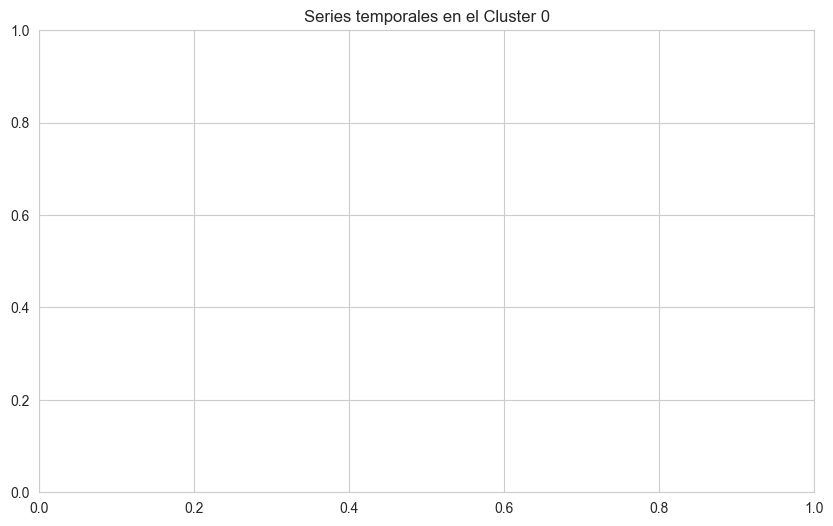

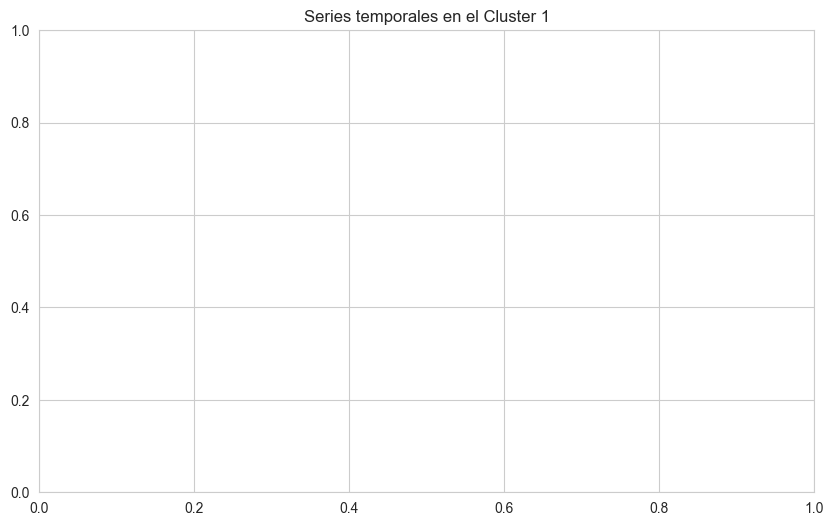

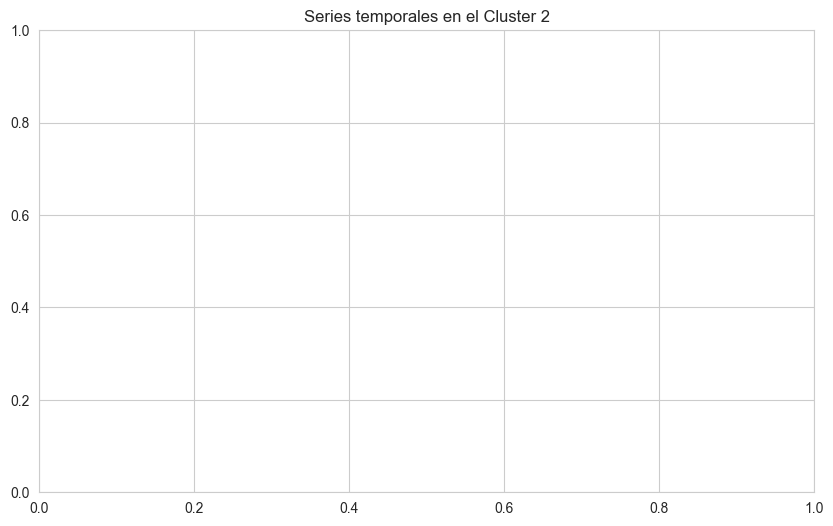

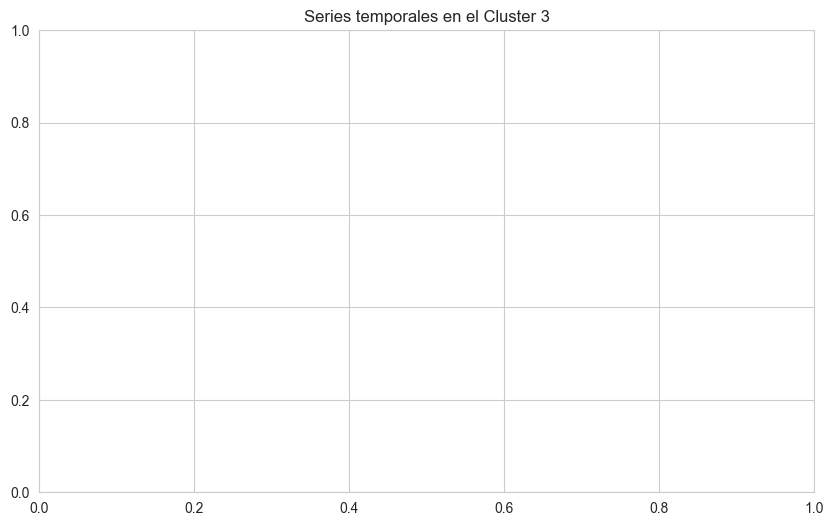

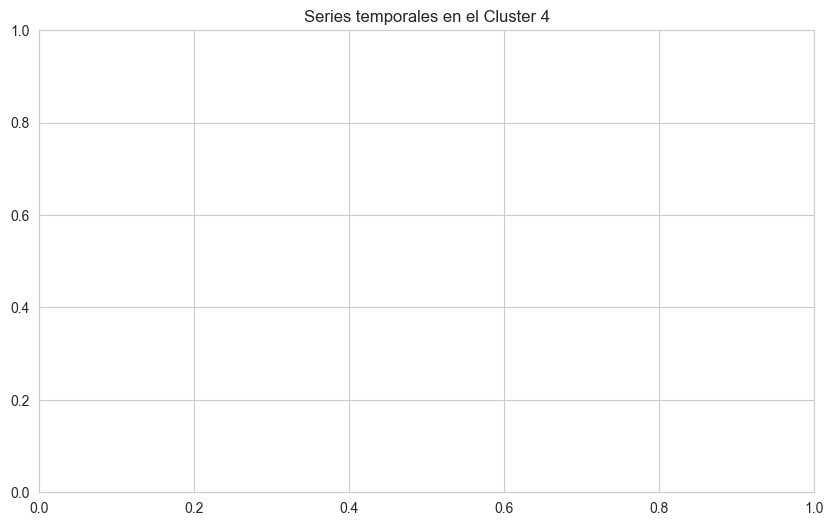

In [ ]:
# Visualizo las series temporales en cada cluster
for cluster in range(n_clusters):
    plt.figure(figsize=(10, 6))
    
    # Selecciona solo las filas que pertenecen al cluster actual
    cluster_df = df[df["cluster"] == cluster]
    
    # Asegúrate de que hay datos en el cluster antes de intentar graficar
    if cluster_df.empty:
        print(f"El Cluster {cluster} está vacío.")
        continue
    
    # Grafica cada serie temporal individual en el cluster
    for unique_id in cluster_df["unique_id"].unique():
        unique_id_series = cluster_df[cluster_df["unique_id"] == unique_id]
        plt.plot(unique_id_series["date"], unique_id_series["monthly_average_price"], alpha=0.5)
    
    plt.title(f"Series temporales en el Cluster {cluster}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio promedio mensual")
    plt.show()
